# Experiment - Abnormal Returns

In [1]:
NAME = '09-05-experiment_car'
PROJECT = 'conference-calls-sentiment'
PYTHON_VERSION = '3.7.0'

### Imports  

In [2]:
import os
import re
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import paper_style

# Stats
from scipy import stats

# Regressions
from linearmodels import PanelOLS
import statsmodels.api as sm

# Hide annoying warnings
import warnings
warnings.filterwarnings('ignore')

### Settings

In [3]:
workdir = re.sub("(?<={})[\w\W]*".format(PROJECT), "", os.getcwd())
os.chdir(workdir)

pipeline = os.path.join('2_pipeline', NAME)
if not os.path.exists(pipeline):
    os.makedirs(pipeline)
    for folder in ['out', 'store', 'tmp']:
        os.makedirs(os.path.join(pipeline, folder))

--- 
# Main code

In [ ]:
dataset = pd.read_feather(os.path.join('2_pipeline', '07-02_dataset_construction', 'out', 'dataset.feather'))
dataset

## Abnormal Returns

In [ ]:
abnormal_returns = pd.read_feather(os.path.join('2_pipeline', '05-01_abnormal_returns', 'out', 'event_study.feather'))
abnormal_returns.head()

In [ ]:
abnormal_return_events = dataset.merge(abnormal_returns, on=['ticker', 'event_date'])
abnormal_return_events.head()

In [7]:
n_cuts = 4
abnormal_return_events['finbert_tone_q'] = pd.qcut(abnormal_return_events['finbert_tone_norm'], q=n_cuts, labels=range(1, n_cuts+1))
abnormal_return_events['lm_tone_q'] = pd.qcut(abnormal_return_events['lm_tone_norm'], q=n_cuts, labels=range(1, n_cuts+1))

In [8]:
high_finbert = abnormal_return_events[abnormal_return_events['finbert_tone_q'] == n_cuts]
low_finbert = abnormal_return_events[abnormal_return_events['finbert_tone_q'] == 1]

high_lm_dictionary = abnormal_return_events[abnormal_return_events['lm_tone_q'] == n_cuts]
low_lm_dictionary = abnormal_return_events[abnormal_return_events['lm_tone_q'] == 1]

In [9]:
high_finbert_ret = high_finbert.groupby('day')['ar'].mean().sum()
low_finbert_ret = low_finbert.groupby('day')['ar'].mean().sum()
high_lm_dictionary_ret = high_lm_dictionary.groupby('day')['ar'].mean().sum()
low_lm_dictionary_ret = low_lm_dictionary.groupby('day')['ar'].mean().sum()

print(f'Finbert (High) {high_finbert_ret:.4%}')
print(f'Finbert (Low) {low_finbert_ret:.4%}')
print(f'LM Dictionary (High) {high_lm_dictionary_ret:.4%}')
print(f'LM Dictionary (Low) {low_lm_dictionary_ret:.4%}')

Finbert (High) 1.8903%
Finbert (Low) -0.7006%
LM Dictionary (High) 1.3590%
LM Dictionary (Low) -0.1619%


In [10]:
def get_daily_car(data):
    return data.groupby('day')['ar'].mean().cumsum()

In [11]:
def line_legend():
    handles, labels = ax.get_legend_handles_labels()
    for line, label in zip(handles, labels):
        x = line.get_xdata()[-1]
        x += 0.05  # Nudge to right
        y = line.get_ydata()[-1]
        if y > 0:
            y *= 0.95  # Nudge to bottom
        else:
            y *= 1.05  # Nugde to top
        c = line.get_color()
        ax.annotate(label, (x, y), color=c)

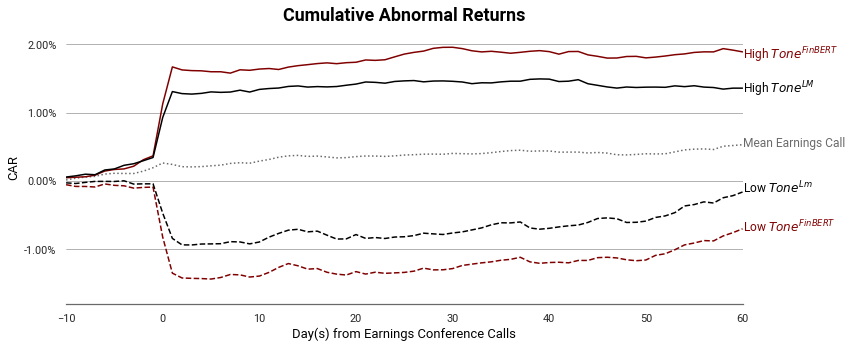

In [12]:
fig, ax = plt.subplots()

# Baseline
abnormal_return_events.pipe(get_daily_car).plot(ax=ax, c='dimgrey', ls=':', label='Mean Earnings Call')

# FinBERT
high_finbert.pipe(get_daily_car).plot(ax=ax, c='maroon',  ls='-', label='High $Tone^{FinBERT}$')
low_finbert.pipe(get_daily_car).plot(ax=ax, c='maroon', ls='--', label='Low $Tone^{FinBERT}$')

# LM Dictionary
high_lm_dictionary.pipe(get_daily_car).plot(ax=ax, c='black', ls='-', label='High $Tone^{LM}$')
low_lm_dictionary.pipe(get_daily_car).plot(ax=ax, c='black', ls='--', label='Low $Tone^{Lm}$')

# Titles
ax.set_title('Cumulative Abnormal Returns')
ax.set_xlabel('Day(s) from Earnings Conference Calls')
ax.set_ylabel('CAR')

# Limites and grid
ax.set_xlim(-10, 60)
ax.set_ylim(-0.018, 0.022)
ax.grid(axis='x')

# Y ticks to percentages
y_ticks = [-0.01, 0, 0.01, 0.02]
ax.set_yticks(y_ticks)
ax.set_yticklabels(['{:,.2%}'.format(y) for y in y_ticks])

# Plot legend label next to line
line_legend()
# # Plot legend below plot
# ax.legend(ncol=5, bbox_to_anchor=(1, -0.20))

fig.tight_layout()
fig.savefig(os.path.join('3_output', 'figures', 'car.pdf'))

## Trading

In [13]:
n_cuts = 4
dataset['finbert_tone_q'] = pd.qcut(dataset['finbert_tone_norm'], q=n_cuts, labels=range(1, n_cuts+1))
dataset['lm_tone_q'] = pd.qcut(dataset['lm_tone_norm'], q=n_cuts, labels=range(1, n_cuts+1))

In [14]:
finbert_long_short = (dataset
                      .loc[dataset['finbert_tone_q'].isin([1,4])]
                      .filter(['event_date', 'finbert_tone_q', 'ret_trade'])
                      .dropna()
                      .assign(ret=lambda x: np.where(x['finbert_tone_q'] == 4, x['ret_trade'], -x['ret_trade']))
                      .groupby(['event_date'])['ret'].sum()
                      .rolling(30, min_periods=1).mean().cumsum())

print(f"Profit: {finbert_long_short.iloc[-1]:,.2f}%")

Profit: 6,149.15%


In [15]:
lm_long_short = (dataset
                 .loc[dataset['lm_tone_q'].isin([1,4])]
                 .filter(['event_date', 'lm_tone_q', 'ret_trade'])
                 .dropna()
                 .assign(ret=lambda x: np.where(x['lm_tone_q'] == 4, x['ret_trade'], -x['ret_trade']))
                 .groupby(['event_date'])['ret'].sum()
                 .rolling(30, min_periods=1).mean().cumsum())

print(f"Profit: {lm_long_short.iloc[-1]:,.2f}%")

Profit: 4,469.93%


In [16]:
all_long = (dataset
            .filter(['event_date', 'ret_trade'])
            .dropna()
            .groupby(['event_date'])['ret_trade'].sum()
            .rolling(30, min_periods=1).mean().cumsum()
            )
print(f"Profit: {all_long.iloc[-1]:,.2f}%")

Profit: 364.56%


In [17]:
def line_labels():
    handles, _ = ax.get_legend_handles_labels()
    for line in handles:
        x = line.get_xdata()[-1]
        x += pd.Timedelta(4, unit='d')
        y = line.get_ydata()[-1]
        y_label = '{:,.2f}x'.format(y/100)
        if y < 2000:
            y *= 0.50    # Nugde to bottom
        c = line.get_color()
        ax.annotate(y_label, (x, y), color=c)

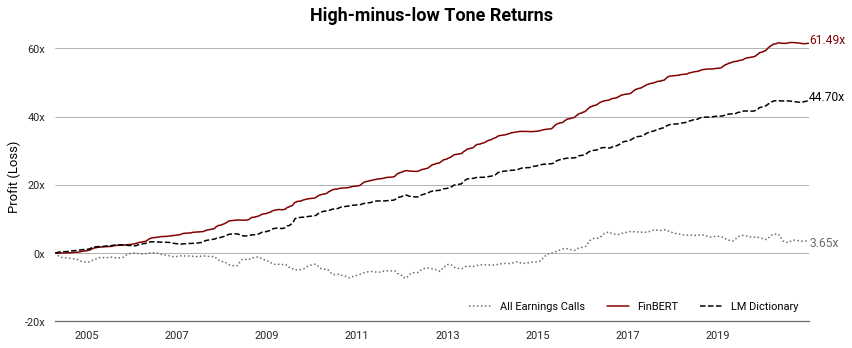

In [18]:
fig, ax = plt.subplots()

# Baseline
all_long.plot(ax=ax, c='dimgrey', ls=':', label='All Earnings Calls')

# FinBERT
finbert_long_short.plot(ax=ax, c='maroon',  ls='-', label='FinBERT')

# LM Dictionary
lm_long_short.plot(ax=ax, c='black', ls='--', label='LM Dictionary')

# Titles
ax.set_title('High-minus-low Tone Returns')
ax.set_xlabel('')
ax.set_ylabel('Profit (Loss)')

# Limites and grid
ax.set_xlim(all_long.index.min(), all_long.index.max())
ax.grid(axis='x')

# Disable X ticks rotation
plt.xticks(rotation=0)

# X Ticks
xticks = np.arange(2005, 2020, 2)
ax.set_xticks([str(x) for x in xticks])
ax.set_xticklabels(xticks)

# Y ticks
yticks = ax.get_yticks()
yticks = yticks[::2]
ax.set_yticks(yticks)
ax.set_yticklabels(['{:,.0f}x'.format(y/100) for y in yticks])

# Plot legend label next to line
line_labels()
# Plot legend below plot
ax.legend(ncol=3, loc=4)

fig.tight_layout()
fig.savefig(os.path.join('3_output', 'figures', 'long_short_returns.pdf'))

## Table

In [19]:
def get_descriptives(data, tone, column):
    return (data.groupby(tone)[column].describe()
                .filter(['mean', '50%'])
                .rename(columns={'mean': 'Mean', '50%': 'Median'})
                .round(3).stack())

In [29]:
lm_car_st = get_descriptives(dataset, 'lm_tone_q', 'car_st')
finbert_car_st = get_descriptives(dataset, 'finbert_tone_q', 'car_st')
lm_car_drift = get_descriptives(dataset, 'lm_tone_q', 'car_drift')
finbert_car_drift = get_descriptives(dataset, 'finbert_tone_q', 'car_drift')

descriptives = pd.concat([lm_car_st, finbert_car_st, lm_car_drift, finbert_car_drift], axis=1)
descriptives.columns = ['$Tone_{LM}$', '$Tone_{FinBERT}$', '$Tone_{LM}$', '$Tone_{FinBERT}$']

descriptives

$Tone_{LM}$  $Tone_{FinBERT}$  $Tone_{LM}$  $Tone_{FinBERT}$
1 Mean         -0.810            -1.275        0.683             0.655
  Median       -0.584            -0.905        0.454             0.445
2 Mean         -0.101            -0.219        0.325             0.232
  Median       -0.034            -0.195        0.492             0.408
3 Mean          0.305             0.529        0.092             0.060
  Median        0.296             0.456        0.476             0.408
4 Mean          1.022             1.375        0.052             0.222
  Median        0.875             1.182        0.366             0.552

In [30]:
print(descriptives.to_latex(escape=False))

\begin{tabular}{llrrrr}
\toprule
  &        &  $Tone_{LM}$ &  $Tone_{FinBERT}$ &  $Tone_{LM}$ &  $Tone_{FinBERT}$ \\
\midrule
1 & Mean &       -0.810 &            -1.275 &        0.683 &             0.655 \\
  & Median &       -0.584 &            -0.905 &        0.454 &             0.445 \\
2 & Mean &       -0.101 &            -0.219 &        0.325 &             0.232 \\
  & Median &       -0.034 &            -0.195 &        0.492 &             0.408 \\
3 & Mean &        0.305 &             0.529 &        0.092 &             0.060 \\
  & Median &        0.296 &             0.456 &        0.476 &             0.408 \\
4 & Mean &        1.022 &             1.375 &        0.052 &             0.222 \\
  & Median &        0.875 &             1.182 &        0.366 &             0.552 \\
\bottomrule
\end{tabular}



In [22]:
lm_q1_st = dataset.loc[dataset['lm_tone_q'] == 1, 'car_st'].dropna().values
lm_q4_st = dataset.loc[dataset['lm_tone_q'] == 4, 'car_st'].dropna().values

tstat = stats.ttest_ind(lm_q4_st, lm_q1_st, equal_var=False)[0]
print('Mean diff:', (lm_q4_st.mean()-lm_q1_st.mean()).round(3))
print(f"t-stat: {tstat:.2f}", end='\n\n')

print('Median diff:', (np.median(lm_q4_st)-np.median(lm_q1_st)).round(3))
z_stat = stats.ranksums(lm_q4_st, lm_q1_st)[0]
print(f"z-stat: {z_stat:.2f}")

Mean diff: 1.831
t-stat: 16.00

Median diff: 1.459
z-stat: 17.30


In [23]:
finbert_q1_st = dataset.loc[dataset['finbert_tone_q'] == 1, 'car_st'].dropna().values
finbert_q4_st = dataset.loc[dataset['finbert_tone_q'] == 4, 'car_st'].dropna().values

tstat = stats.ttest_ind(finbert_q4_st, finbert_q1_st, equal_var=False)[0]
print('Mean diff:', (finbert_q4_st.mean()-finbert_q1_st.mean()).round(3))
print(f"t-stat: {tstat:.2f}", end='\n\n')

print('Median diff:', (np.median(finbert_q4_st)-np.median(finbert_q1_st)).round(3))
z_stat = stats.ranksums(finbert_q4_st, finbert_q1_st)[0]
print(f"z-stat: {z_stat:.2f}")

Mean diff: 2.65
t-stat: 22.79

Median diff: 2.087
z-stat: 23.85


In [34]:
lm_q1_drift = dataset.loc[dataset['lm_tone_q'] == 1, 'car_drift'].dropna().values
lm_q4_drift = dataset.loc[dataset['lm_tone_q'] == 4, 'car_drift'].dropna().values

tstat = stats.ttest_ind(lm_q4_drift, lm_q1_drift, equal_var=False)[0]
print('Mean diff:', (lm_q4_drift.mean()-lm_q1_drift.mean()).round(3))
print(f"t-stat: {tstat:.2f}", end='\n\n')

print('Median diff:', (np.median(lm_q4_drift)-np.median(lm_q1_drift)).round(3))
z_stat = stats.ranksums(lm_q4_drift, lm_q1_drift)[0]
print(f"z-stat: {z_stat:.2f}")

Mean diff: -0.632
t-stat: -2.70

Median diff: -0.088
z-stat: -1.06


In [57]:
finbert_q1_drift = dataset.loc[dataset['finbert_tone_q'] == 1, 'car_drift'].dropna().values
finbert_q4_drift = dataset.loc[dataset['finbert_tone_q'] == 4, 'car_drift'].dropna().values

tstat = stats.ttest_ind(finbert_q4_drift, finbert_q1_drift, equal_var=False)[0]
print('Mean diff:', (finbert_q4_drift.mean()-finbert_q1_drift.mean()).round(3))
print(f"t-stat: {tstat:.2f}", end='\n\n')

print('Median diff:', (np.median(finbert_q4_drift)-np.median(finbert_q1_drift)).round(3))
z_stat = stats.ranksums(finbert_q4_drift, finbert_q1_drift)[0]
print(f"z-stat: {z_stat:.2f}")

Mean diff: -0.433
t-stat: -1.86

Median diff: 0.107
z-stat: -0.32


## Regression

In [58]:
def ols_model(df, dependent, tone, controls, ffe, tfe):
    if controls:
        exog = [tone] + ['num_words', 'surprise', 'size', 'roa', 'leverage', 'loss', 'capex']
    else:
        exog = [tone]

    dependent = df[dependent]
    exog = sm.add_constant(df[exog])
    model = PanelOLS(dependent, exog, entity_effects=ffe, time_effects=tfe)
    return model.fit(cov_type='clustered', cluster_entity=True)

In [59]:
ols_model(dataset.set_index(['gvkey', 'year']), 'car_st', 'lm_tone_norm', controls=True, ffe=False, tfe=False)

Dep. Variable:,car_st,R-squared:,0.0184
Estimator:,PanelOLS,R-squared (Between):,0.0479
No. Observations:,21967,R-squared (Within):,0.0197
Date:,"Thu, May 13 2021",R-squared (Overall):,0.0184
Time:,20:53:41,Log-likelihood,-7.059e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,51.438
Entities:,598,P-value,0.0000
Avg Obs:,36.734,Distribution:,"F(8,21958)"
Min Obs:,1.0000,,
Max Obs:,68.000,F-statistic (robust):,29.803


In [60]:
ols_model(dataset.set_index(['gvkey', 'year']), 'car_st', 'lm_tone_norm', controls=True, ffe=True, tfe=True)

Dep. Variable:,car_st,R-squared:,0.0304
Estimator:,PanelOLS,R-squared (Between):,-0.5024
No. Observations:,21967,R-squared (Within):,0.0293
Date:,"Thu, May 13 2021",R-squared (Overall):,-0.0531
Time:,20:53:41,Log-likelihood,-7.004e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,83.630
Entities:,598,P-value,0.0000
Avg Obs:,36.734,Distribution:,"F(8,21345)"
Min Obs:,1.0000,,
Max Obs:,68.000,F-statistic (robust):,46.507


In [61]:
ols_model(dataset.set_index(['gvkey', 'year']), 'car_st', 'finbert_tone_norm', controls=True, ffe=False, tfe=False)

Dep. Variable:,car_st,R-squared:,0.0327
Estimator:,PanelOLS,R-squared (Between):,-0.0102
No. Observations:,21967,R-squared (Within):,0.0375
Date:,"Thu, May 13 2021",R-squared (Overall):,0.0327
Time:,20:53:42,Log-likelihood,-7.043e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,92.897
Entities:,598,P-value,0.0000
Avg Obs:,36.734,Distribution:,"F(8,21958)"
Min Obs:,1.0000,,
Max Obs:,68.000,F-statistic (robust):,45.264


In [62]:
ols_model(dataset.set_index(['gvkey', 'year']), 'car_st', 'finbert_tone_norm', controls=True, ffe=True, tfe=True)

Dep. Variable:,car_st,R-squared:,0.0515
Estimator:,PanelOLS,R-squared (Between):,-0.5917
No. Observations:,21967,R-squared (Within):,0.0500
Date:,"Thu, May 13 2021",R-squared (Overall):,-0.0384
Time:,20:53:42,Log-likelihood,-6.98e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,144.80
Entities:,598,P-value,0.0000
Avg Obs:,36.734,Distribution:,"F(8,21345)"
Min Obs:,1.0000,,
Max Obs:,68.000,F-statistic (robust):,63.156
